In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [2]:
BATCHSIZE=64
data_dir = '../fish'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=BATCHSIZE)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=BATCHSIZE)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)


['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_06', 'fish_07', 'fish_08', 'fish_09', 'fish_10', 'fish_11', 'fish_12', 'fish_13', 'fish_14', 'fish_15', 'fish_16']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 16),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
epochs = 10
steps = 0
running_loss = 0
print_every = 16
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model,'model.pth')

Epoch 1/10.. Train loss: 2.294.. Test loss: 1.189.. Test accuracy: 0.666
Epoch 1/10.. Train loss: 1.025.. Test loss: 0.831.. Test accuracy: 0.729
Epoch 1/10.. Train loss: 0.710.. Test loss: 0.563.. Test accuracy: 0.849
Epoch 1/10.. Train loss: 0.614.. Test loss: 0.538.. Test accuracy: 0.845
Epoch 1/10.. Train loss: 0.531.. Test loss: 0.408.. Test accuracy: 0.877
Epoch 1/10.. Train loss: 0.565.. Test loss: 0.414.. Test accuracy: 0.879
Epoch 1/10.. Train loss: 0.491.. Test loss: 0.406.. Test accuracy: 0.882
Epoch 1/10.. Train loss: 0.536.. Test loss: 0.387.. Test accuracy: 0.880
Epoch 1/10.. Train loss: 0.382.. Test loss: 0.366.. Test accuracy: 0.892
Epoch 1/10.. Train loss: 0.411.. Test loss: 0.278.. Test accuracy: 0.918
Epoch 1/10.. Train loss: 0.418.. Test loss: 0.365.. Test accuracy: 0.883
Epoch 1/10.. Train loss: 0.420.. Test loss: 0.301.. Test accuracy: 0.902
Epoch 1/10.. Train loss: 0.346.. Test loss: 0.266.. Test accuracy: 0.920
Epoch 1/10.. Train loss: 0.325.. Test loss: 0.281..

Epoch 6/10.. Train loss: 0.226.. Test loss: 0.172.. Test accuracy: 0.945
Epoch 6/10.. Train loss: 0.215.. Test loss: 0.188.. Test accuracy: 0.945
Epoch 6/10.. Train loss: 0.239.. Test loss: 0.160.. Test accuracy: 0.952
Epoch 6/10.. Train loss: 0.206.. Test loss: 0.151.. Test accuracy: 0.953
Epoch 6/10.. Train loss: 0.190.. Test loss: 0.221.. Test accuracy: 0.933
Epoch 6/10.. Train loss: 0.197.. Test loss: 0.176.. Test accuracy: 0.946
Epoch 6/10.. Train loss: 0.215.. Test loss: 0.150.. Test accuracy: 0.949
Epoch 6/10.. Train loss: 0.206.. Test loss: 0.159.. Test accuracy: 0.952
Epoch 6/10.. Train loss: 0.201.. Test loss: 0.213.. Test accuracy: 0.932
Epoch 6/10.. Train loss: 0.217.. Test loss: 0.213.. Test accuracy: 0.935
Epoch 6/10.. Train loss: 0.323.. Test loss: 0.180.. Test accuracy: 0.944
Epoch 6/10.. Train loss: 0.275.. Test loss: 0.167.. Test accuracy: 0.952
Epoch 6/10.. Train loss: 0.238.. Test loss: 0.161.. Test accuracy: 0.950
Epoch 6/10.. Train loss: 0.181.. Test loss: 0.193..

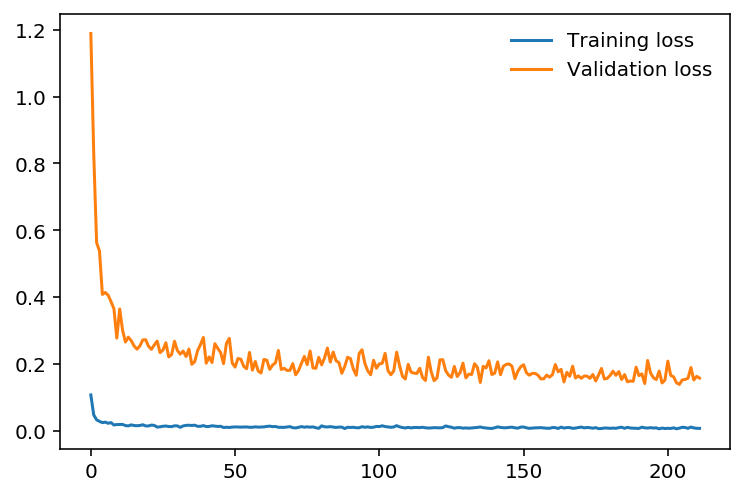

In [6]:

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()